### Isochrones - Binary Model Pipeline

In [2]:
import astropy.table as astab
from isochrones import BinaryStarModel,get_ichrone
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from corner import corner
import arviz as az

Holoviews not imported. Some visualizations will not be available.


In [3]:
hq_joker_edr3_apogee_tess_df = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/unimodal_joker_sample_joined_w_tess_edr3_REDUX.fits").to_pandas()

In [4]:
### PILFERED AND MODIFIED FROM MARINA KOUNKEL'S GITHUB REPOSITORY FOR THE AURIGA NEURAL NET

def get_2mass_mag_uncertainties(data):
    from astroquery.gaia import Gaia
    table=astab.Table([data['source_id']],names=['source_id'])
    j = Gaia.launch_job_async(query="select g.source_id,tm.j_msigcom as ej,tm.h_msigcom as eh,tm.ks_msigcom as ek \
        FROM gaiadr2.gaia_source AS g \
        inner join TAP_UPLOAD.table_test AS tc \
        ON g.source_id = tc.source_id \
        LEFT OUTER JOIN gaiadr2.tmass_best_neighbour AS xmatch \
        ON g.source_id = xmatch.source_id \
        LEFT OUTER JOIN gaiadr1.tmass_original_valid AS tm \
        ON tm.tmass_oid = xmatch.tmass_oid", upload_resource=table, upload_table_name="table_test")
    d = j.get_results().to_pandas()
    return d

In [6]:
ticrow = hq_joker_edr3_apogee_tess_df.loc[hq_joker_edr3_apogee_tess_df['ID'] == 272074664]
tmass_errs = get_2mass_mag_uncertainties(ticrow)
print(tmass_errs)

INFO: Query finished. [astroquery.utils.tap.core]
             source_id     ej     eh     ek
0  2080382858538553344  0.021  0.019  0.012


In [7]:
def generate_params_for_multinest(ticnum):
    
    ticrow = hq_joker_edr3_apogee_tess_df.loc[hq_joker_edr3_apogee_tess_df['ID'] == ticnum]
    
    tmass_errs = get_2mass_mag_uncertainties(ticrow)
    if tmass_errs.shape[0] > 0:
        assert tmass_errs.source_id.squeeze() == ticrow['source_id'].squeeze()
        eh,ej,ek = tmass_errs.eh.squeeze(), tmass_errs.ej.squeeze(), tmass_errs.ek.squeeze()
    if tmass_errs.shape[0] == 0:
        eh,ej,ek = 0.02,0.02,0.02
    g = ticrow.phot_g_mean_mag.squeeze()
    bp = ticrow.phot_bp_mean_mag.squeeze()
    rp = ticrow.phot_rp_mean_mag.squeeze()
    eg = (-2.5*np.log10(ticrow.phot_g_mean_flux.squeeze()-ticrow.phot_g_mean_flux_error.squeeze()) 
          + 2.5*np.log10(ticrow.phot_g_mean_flux.squeeze()+ticrow.phot_g_mean_flux_error.squeeze())) / 2.
    ebp = (-2.5*np.log10(ticrow.phot_bp_mean_flux.squeeze()-ticrow.phot_bp_mean_flux_error.squeeze()) 
          + 2.5*np.log10(ticrow.phot_bp_mean_flux.squeeze()+ticrow.phot_bp_mean_flux_error.squeeze())) / 2.
    erp = (-2.5*np.log10(ticrow.phot_rp_mean_flux.squeeze()-ticrow.phot_rp_mean_flux_error.squeeze()) 
          + 2.5*np.log10(ticrow.phot_rp_mean_flux.squeeze()+ticrow.phot_rp_mean_flux_error.squeeze())) / 2.
#     print(eg, ebp, erp)
    params = {
#         'Teff':(ticrow.TEFF.squeeze(),ticrow.TEFF_ERR.squeeze()),
#         'logg':(ticrow.LOGG.squeeze(),ticrow.LOGG_ERR.squeeze()),
#         'feh':(ticrow.FE_H.squeeze(), ticrow.FE_H_ERR.squeeze()),
        'H':(ticrow.H.squeeze(), eh),
        'J':(ticrow.J.squeeze(), ej),
        'K':(ticrow.K.squeeze(), ek),
        'BP':(bp, ebp),
        'RP':(rp, erp),
        'G':(g, eg),
        'parallax':(ticrow.parallax.squeeze(), ticrow.parallax_error.squeeze())
    }
    
    return params

In [9]:
ticparams = generate_params_for_multinest(272074664)
# print(ticparams['feh'])
print(ticparams)

INFO: Query finished. [astroquery.utils.tap.core]
{'H': (11.057, 0.019), 'J': (11.334, 0.021), 'K': (11.004, 0.012), 'BP': (12.701813, 0.0007651482474368976), 'RP': (11.898719, 0.00045409143450392264), 'G': (12.381759, 0.00019630817568749848), 'parallax': (1.5356266264694423, 0.008667543)}


In [10]:
def initialize_multinest_binary_model(ticnum):
    from isochrones.priors import GaussianPrior
    params = generate_params_for_multinest(ticnum)
    
    mist = get_ichrone('mist', bands=['J','H','K','BP','RP','G'])
    
    binarymodel = BinaryStarModel(mist, **params, name=f'TIC_{ticnum}')
    
    distance = 1000./params['parallax'][0]
#     feh_bounds = (params['feh'][0]-3*params['feh'][1], params['feh'][0]+3*params['feh'][1])
#     print(feh_bounds)
    plus_dist = (1000./(params['parallax'][0] + params['parallax'][1]))
    mins_dist = (1000./(params['parallax'][0] - params['parallax'][1]))
#     print(plus_dist, mins_dist)
    
    mdist_diff = distance - min(plus_dist, mins_dist)
    pdist_diff = max(plus_dist, mins_dist) - distance
    
    edist_estimate = (mdist_diff + pdist_diff) / 2.
    
    binarymodel.set_bounds(eep=(202,800), age=(6,11.))
    binarymodel.set_prior(distance=GaussianPrior(distance, 3*edist_estimate, 
                                                 bounds=(distance-6*edist_estimate, distance+6*edist_estimate)))
#     print(5.*mdist_diff, distance, 5.*pdist_diff)
    return binarymodel

In [12]:
binmod = initialize_multinest_binary_model(99254945)
print('/Users/kjaehnig'+binmod.mnest_basename[1:])
binmod.mnest_basename = '/Users/kjaehnig'+binmod.mnest_basename[1:]
binmod.fit(n_live_points=1000,overwrite=True)

INFO: Query finished. [astroquery.utils.tap.core]
/Users/kjaehnig/chains/TIC_99254945-mist-binary-
 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    6
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.998099
Replacements:                               1050
Total Samples:                              1052
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):   -2642.788655 +/-  0.999525
Acceptance Rate:                        0.992780
Replacements:                               1100
Total Samples:                              1108
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):   -2642.840519 +/-  0.999549

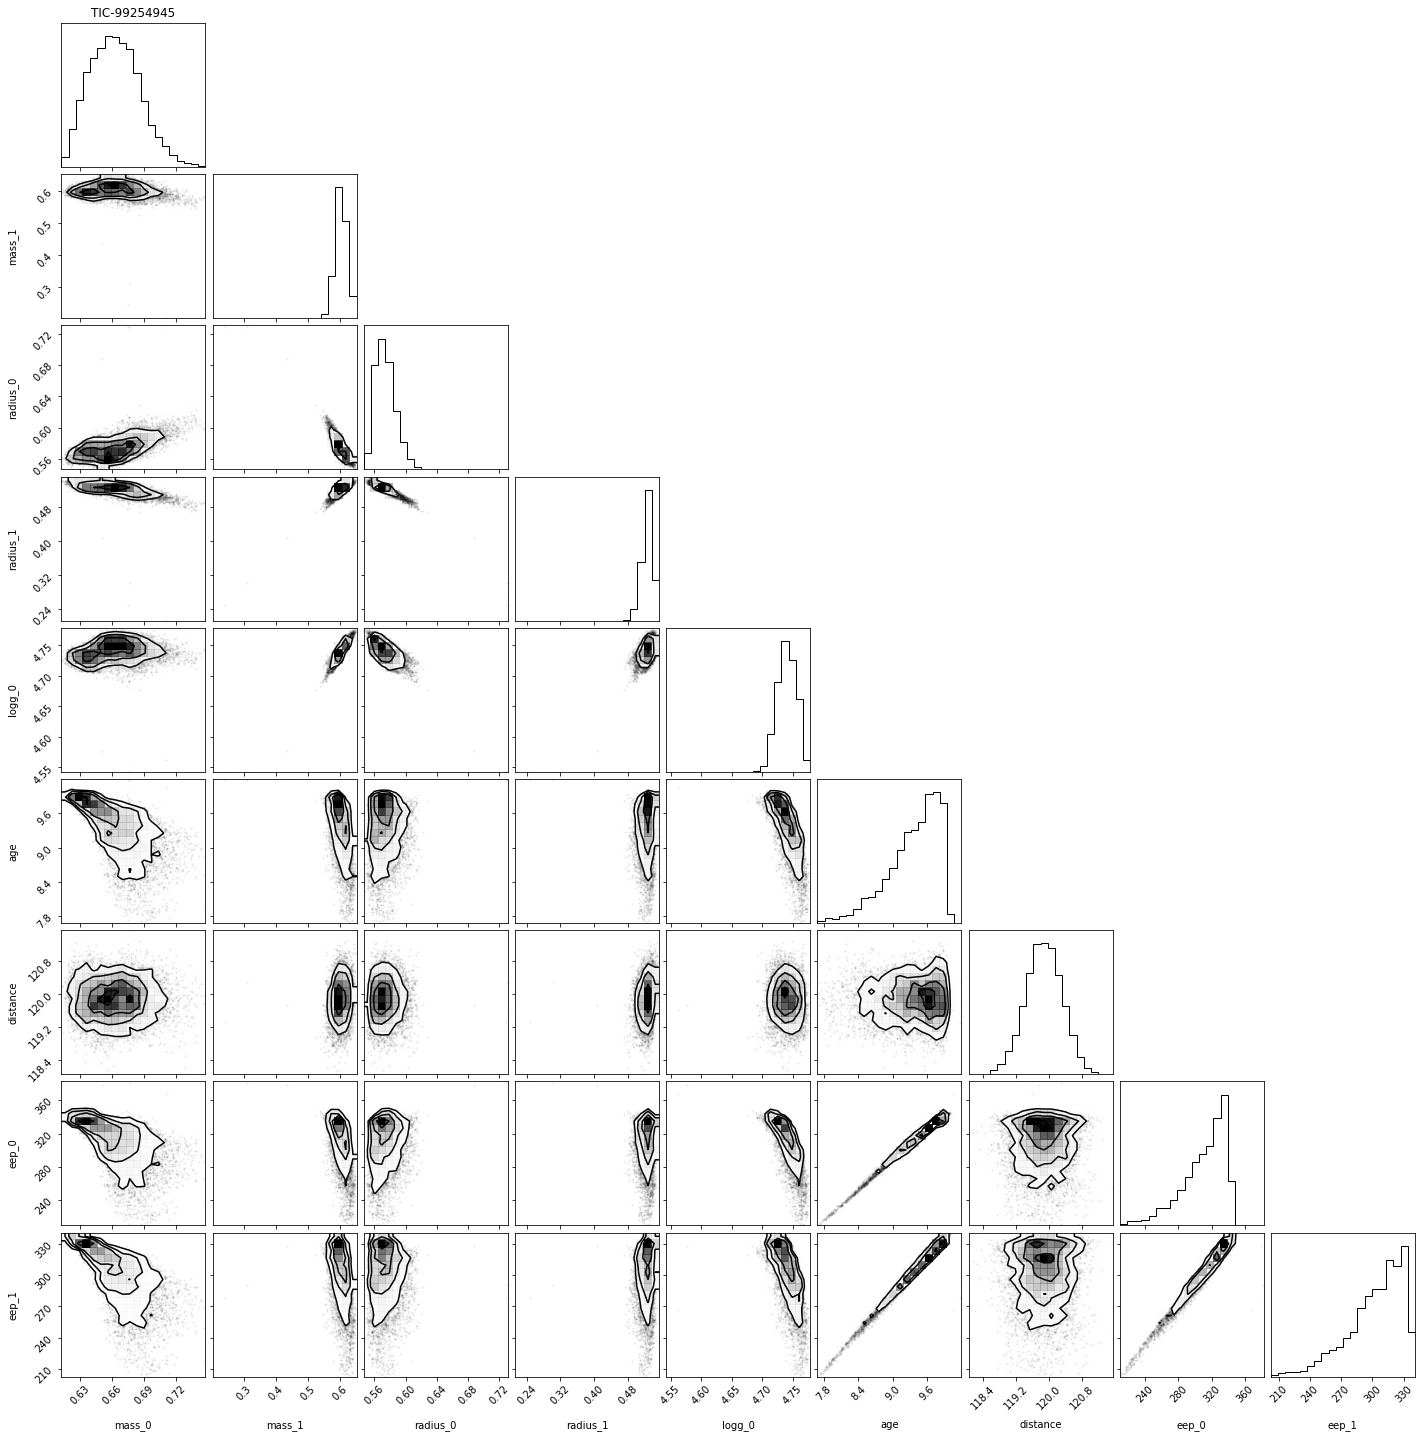

In [13]:
fig = corner(az.from_dict(binmod.derived_samples[['mass_0','mass_1','radius_0','radius_1','logg_0','age', 'distance','eep_0','eep_1']].to_dict('list')),
            truths=[None, None, None, None, None, None, 1000./ticparams['parallax'][0], None, None])
fig.axes[0].set_title("TIC-99254945")
plt.savefig("testcorner.png",dpi=150,bbox_inches='tight')

In [14]:
tic_systems_of_interest = [28159019,99254945,126232983,164458426,164527723,165453878,169820068,258108067,271548206,272074664,20215452,144441148,365204192]

In [15]:
file = open("/Users/kjaehnig/CCA_work/GAT/tic_systems_of_interest.txt",'w')
for ticnum in tic_systems_of_interest:
    file.write(f'TIC_{ticnum}\n')
file.close()

In [16]:
# for ticsystem in tic_systems_of_interest:
#     binmod = initialize_multinest_binary_model(ticsystem)
#     binmod.fit(n_live_points=2000, overwrite=True)
#     fig = corner(az.from_dict(binmod.derived_samples[['mass_0','mass_1','logg_0','logg_1','Teff_0','Teff_1','distance']].to_dict('list')))
#     fig.axes[0].set_title(f'TIC-{ticsystem}')
#     plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/tic_{ticsystem}_multinest_corner.pngdpi=150",bbox_inches='tight')
#     plt.close()
#     binmod.save_hdf(f"/Users/kjaehnig/CCA_work/GAT/pymultinest_fits/tic_{ticsystem}_binary_model_obj.hdf",overwrite=True)

In [19]:
tic4664mod= BinaryStarModel.load_hdf("/Users/kjaehnig/CCA_work/GAT/pymultinest_fits/tic_272074664_binary_model_obj.hdf")

Index(['eep_0', 'eep_1', 'age', 'feh', 'distance', 'AV', 'lnprob', 'feh_0',
       'mass_0', 'initial_mass_0', 'radius_0', 'density_0', 'logTeff_0',
       'Teff_0', 'logg_0', 'logL_0', 'Mbol_0', 'delta_nu_0', 'nu_max_0',
       'phase_0', 'dm_deep_0', 'J_mag_0', 'H_mag_0', 'K_mag_0', 'BP_mag_0',
       'RP_mag_0', 'G_mag_0', 'feh_1', 'mass_1', 'initial_mass_1', 'radius_1',
       'density_1', 'logTeff_1', 'Teff_1', 'logg_1', 'logL_1', 'Mbol_1',
       'delta_nu_1', 'nu_max_1', 'phase_1', 'dm_deep_1', 'J_mag_1', 'H_mag_1',
       'K_mag_1', 'BP_mag_1', 'RP_mag_1', 'G_mag_1', 'H_mag', 'J_mag', 'K_mag',
       'BP_mag', 'RP_mag', 'G_mag', 'parallax'],
      dtype='object')


Text(0.5, 1.0, 'TIC-272074664')

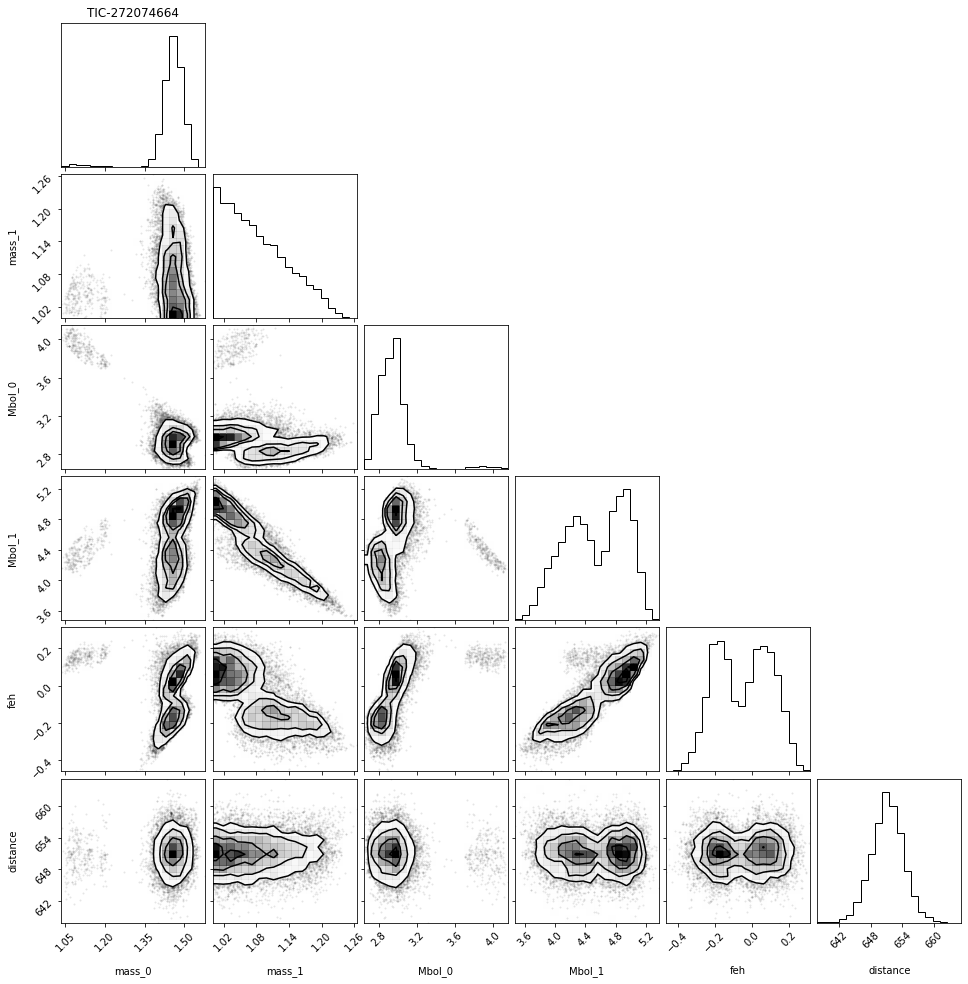

In [20]:
m0,m1,r0, r1 = binmod.derived_samples[['mass_0','mass_1','radius_0', 'radius_1']].median()
print(tic4664mod.derived_samples.columns)
fig = corner(az.from_dict(tic4664mod.derived_samples[['mass_0','mass_1','Mbol_0','Mbol_1','feh','distance']].to_dict('list')))
fig.axes[0].set_title("TIC-272074664")

In [21]:
def get_isochrones_multivariate_dist(TIC_TARGET):
    from isochrones import BinaryStarModel
    ID = TIC_TARGET.split(' ')[1]
    mod = BinaryStarModel.load_hdf(f"/Users/kjaehnig/CCA_work/GAT/pymultinest_fits/tic_{ID}_binary_model_obj.hdf")
    m0,m1,r0,r1 = mod.derived_samples[['mass_0','mass_1','radius_0', 'radius_1']].values.T
    
    
    num,denom = np.argmin([m0.mean(),m1.mean()]), np.argmax([m0.mean(),m1.mean()])
    print(m0,m1,num,denom)
    mbol_0, mbol_1 = mod.derived_samples.Mbol_0.values,mod.derived_samples.Mbol_1.values
    s = [mbol_0,mbol_1][num] / [mbol_0,mbol_1][denom]
    q = [m0,m1][num] / [m0,m1][denom]
    k = [r0,r1][num] / [r0,r1][denom]
    
    print(m0,m1,mbol_0,mbol_1)
    m1, r1, q, k, s = ([m0,m1][denom],
                        [r0,r1][denom],
                        q,k,s
                       )
    iso_multD = np.array([np.log(m1), np.log(r1), np.log(q), np.log(k), np.log(s)])
    
    MV_mu = np.mean(iso_multiD, axis=-1)
    MV_cov = np.cov(iso_multiD)
    
    return (MV_mu, MV_cov)
# m1, r1, q, k, s= get_isochrones_multivariate_dist("TIC 272074664")

In [29]:
def generate_params_for_interp(ticnum):
    
    ticrow = hq_joker_edr3_apogee_tess_df.loc[hq_joker_edr3_apogee_tess_df['ID'] == ticnum]
    
    tmass_errs = get_2mass_mag_uncertainties(ticrow)
    if tmass_errs.shape[0] > 0:
        assert tmass_errs.source_id.squeeze() == ticrow['source_id'].squeeze()
        eh,ej,ek = tmass_errs.eh.squeeze(), tmass_errs.ej.squeeze(), tmass_errs.ek.squeeze()
    if tmass_errs.shape[0] == 0:
        eh,ej,ek = 0.02,0.02,0.02
    g = ticrow.phot_g_mean_mag.squeeze()
    bp = ticrow.phot_bp_mean_mag.squeeze()
    rp = ticrow.phot_rp_mean_mag.squeeze()
    eg = (-2.5*np.log10(ticrow.phot_g_mean_flux.squeeze()-ticrow.phot_g_mean_flux_error.squeeze()) 
          + 2.5*np.log10(ticrow.phot_g_mean_flux.squeeze()+ticrow.phot_g_mean_flux_error.squeeze())) / 2.
    ebp = (-2.5*np.log10(ticrow.phot_bp_mean_flux.squeeze()-ticrow.phot_bp_mean_flux_error.squeeze()) 
          + 2.5*np.log10(ticrow.phot_bp_mean_flux.squeeze()+ticrow.phot_bp_mean_flux_error.squeeze())) / 2.
    erp = (-2.5*np.log10(ticrow.phot_rp_mean_flux.squeeze()-ticrow.phot_rp_mean_flux_error.squeeze()) 
          + 2.5*np.log10(ticrow.phot_rp_mean_flux.squeeze()+ticrow.phot_rp_mean_flux_error.squeeze())) / 2.
#     print(eg, ebp, erp)
    params = {
        'Teff':(ticrow.TEFF.squeeze(),ticrow.TEFF_ERR.squeeze()),
        'logg':(ticrow.LOGG.squeeze(),ticrow.LOGG_ERR.squeeze()),
        'feh':(ticrow.FE_H.squeeze(), ticrow.FE_H_ERR.squeeze()),
        'H':(ticrow.H.squeeze(), eh),
        'J':(ticrow.J.squeeze(), ej),
        'K':(ticrow.K.squeeze(), ek),
        'BP':(bp, ebp),
        'RP':(rp, erp),
        'G':(g, eg),
        'parallax':(ticrow.parallax.squeeze(), ticrow.parallax_error.squeeze())
    }
    
    return params

In [23]:
tic_params = generate_params_for_interp(272074664)

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [24]:
from isochrones.mist import MISTEvolutionTrackGrid
track_grid = MISTEvolutionTrackGrid()
eep_range = np.linspace(1, 1000, 1000)
print(tic_params['feh'], tic_params['logg'],tic_params['Teff'])

(0.15782, 0.0044991374) (4.06379, 0.017926387) (5878.9424, 26.77483)


In [25]:
from tqdm import tqdm
min_logg = tic_params['logg'][0] - 0.5
max_logg = tic_params['logg'][0] + 0.5
min_teff = tic_params['Teff'][0] - 100
max_teff = tic_params['Teff'][0] + 100
# print(tic_params['feh'])
valid_ages, valid_eeps, valid_mass = [], [], []
for masses in tqdm(np.linspace(0.1,10,1000), position=0, leave='None'):
    for eep in eep_range:
        interp_vals = track_grid.interp([tic_params['feh'][0], masses, eep], ['age','Teff','logg'])[0]
        age, teff, logg = interp_vals[0], interp_vals[1], interp_vals[2]
        if np.isfinite([age, teff, logg]).sum() == 3:
            bound1 = teff > min_teff
            bound2 = teff < max_teff
            bound3 = logg > min_logg
            bound4 = logg < max_logg
            if bound1 & bound2 & bound3 & bound4:
                valid_ages.append(age)
                valid_eeps.append(eep)
                valid_mass.append(masses)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.49it/s]


In [26]:
print(min(valid_ages), max(valid_ages))
print(min(valid_eeps), max(valid_eeps))
print(min(valid_mass), max(valid_mass))

6.317384959933722 9.903114717810984
165.0 462.0
1.0414414414414417 2.775675675675676


In [27]:
binmod = initialize_multinest_binary_model(272074664)

INFO:astroquery:Query finished.


INFO: Query finished. [astroquery.utils.tap.core]


In [28]:
binmod.set_bounds(eep=(min(valid_eeps), max(valid_eeps)),
                  age=(min(valid_ages), max(valid_ages)),
                  mass=(max(0.1, min(valid_mass)), min(10, max(valid_mass)))
                 )

In [1]:
# binmod.fit(n_live_points=1000,overwrite=True)